https://github.com/altdeep/causalAI/blob/master/book/chapter%2011/Chapter_11_Bayesian_Causal_Graphical_Inference.ipynb

In [1]:
import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import optax
import polars as pl
from flax import nnx
from jax import random
from numpyro.contrib.module import nnx_module
from numpyro.handlers import condition, do
from numpyro.infer import SVI, Predictive, Trace_ELBO

numpyro.set_host_device_count(n=10)

rng_key = random.PRNGKey(seed=42)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

In [2]:
data_path = "https://raw.githubusercontent.com/altdeep/causalML/master/datasets/online_game_ate.csv"

raw_df = pl.read_csv(data_path)


columns_to_keep = [
    "Guild Membership",
    "Side-quest Engagement",
    "Won Items",
    "In-game Purchases",
]

df = raw_df[columns_to_keep]

df.head()

Guild Membership,Side-quest Engagement,Won Items,In-game Purchases
i64,i64,i64,f64
0,1,1,1030.29
0,1,0,2453.34
0,1,1,3761.4
1,1,1,1007.84
0,1,0,4153.94


In [3]:
is_guild_member = df["Guild Membership"].to_jax()
is_highly_engaged = df["Side-quest Engagement"].to_jax()
won_items = df["Won Items"].to_jax()
in_game_purchases = df["In-game Purchases"].to_jax()

In [4]:
class Confounders2Engagement(nnx.Module):
    def __init__(
        self,
        input_dim: int = 1 + 1,
        output_dim: int = 1,
        hidden_dim: int = 5,
        *,
        rngs: nnx.Rngs,
    ) -> None:
        self.fc1 = nnx.Linear(input_dim, hidden_dim, rngs=rngs)
        self.f_engagement_ρ = nnx.Linear(hidden_dim, 1, rngs=rngs)

    def __call__(self, x: jax.Array) -> jax.Array:
        hidden = jax.nn.softplus(self.fc1(x))
        ρ_engagement = jax.nn.sigmoid(self.f_engagement_ρ(hidden))
        return ρ_engagement.T.squeeze(0)


class PurchasesNetwork(nnx.Module):
    def __init__(
        self,
        input_dim=1 + 1 + 1,
        hidden_dim=5,
        *,
        rngs: nnx.Rngs,
    ):
        super().__init__()
        self.f_hidden = nnx.Linear(input_dim, hidden_dim, rngs=rngs)
        self.f_purchase_μ = nnx.Linear(hidden_dim, 1, rngs=rngs)
        self.f_purchase_σ = nnx.Linear(hidden_dim, 1, rngs=rngs)

    def __call__(self, x: jax.Array) -> tuple[jax.Array, jax.Array]:
        hidden = jax.nn.softplus(self.f_hidden(x))
        μ_purchases = self.f_purchase_μ(hidden)
        σ_purchases = 1e-6 + jax.nn.softplus(self.f_purchase_σ(hidden))
        μ_purchases = μ_purchases.T.squeeze(0)
        σ_purchases = σ_purchases.T.squeeze(0)
        return μ_purchases, σ_purchases

In [5]:
rng_key, rng_subkey = random.split(rng_key)
nn_confounders_2_engagement = Confounders2Engagement(rngs=nnx.Rngs(rng_subkey))

rng_key, rng_subkey = random.split(rng_key)
nn_purchases_network = PurchasesNetwork(rngs=nnx.Rngs(rng_subkey))

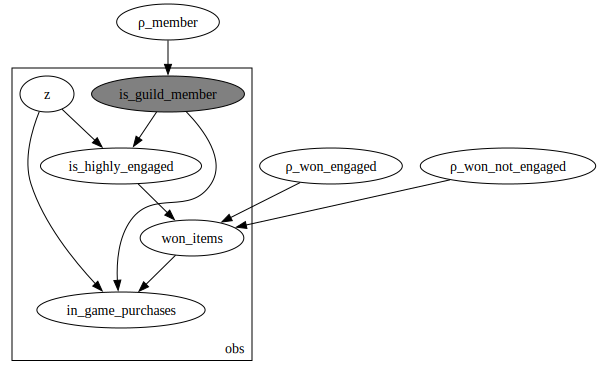

In [6]:
def model(is_guild_member, is_highly_engaged, won_items, in_game_purchases):
    n_obs = is_guild_member.shape[0]

    ρ_member = numpyro.sample("ρ_member", dist.Beta(2, 5))

    ρ_won_engaged = numpyro.sample("ρ_won_engaged", dist.Beta(5, 2))
    ρ_won_not_engaged = numpyro.sample("ρ_won_not_engaged", dist.Beta(2, 5))

    with numpyro.plate("obs", n_obs):
        z = numpyro.sample("z", dist.Normal(0.0, 1.0))

        is_guild_member = numpyro.sample(
            "is_guild_member", dist.Bernoulli(ρ_member), obs=is_guild_member
        )

        engagement_input = jnp.stack((is_guild_member, z)).T

        nnx_confounders_2_engagement = nnx_module(
            "nnx_confounders_2_engagement", nn_confounders_2_engagement
        )

        ρ_engagement = nnx_confounders_2_engagement(engagement_input)

        is_highly_engaged = numpyro.sample(
            "is_highly_engaged",
            dist.Bernoulli(ρ_engagement),
        )

        p_won = ρ_won_engaged * is_highly_engaged + ρ_won_not_engaged * (
            1 - is_highly_engaged
        )

        won_items = numpyro.sample("won_items", dist.Bernoulli(p_won))

        purchase_input = jnp.stack((won_items, is_guild_member, z)).T

        nnx_purchases_network = nnx_module(
            "nnx_purchases_network", nn_purchases_network
        )
        μ_purchases, σ_purchases = nnx_purchases_network(purchase_input)
        numpyro.sample("in_game_purchases", dist.Normal(μ_purchases, σ_purchases))


numpyro.render_model(
    model,
    model_kwargs={
        "is_guild_member": is_guild_member,
        "is_highly_engaged": is_highly_engaged,
        "won_items": won_items,
        "in_game_purchases": in_game_purchases,
    },
)

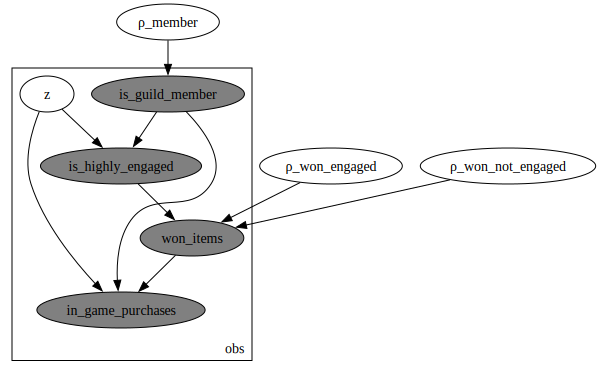

In [7]:
conditioned_model = condition(
    model,
    data={
        "is_highly_engaged": is_highly_engaged,
        "won_items": won_items,
        "in_game_purchases": in_game_purchases,
    },
)

numpyro.render_model(
    conditioned_model,
    model_kwargs={
        "is_guild_member": is_guild_member,
        "is_highly_engaged": is_highly_engaged,
        "won_items": won_items,
        "in_game_purchases": in_game_purchases,
    },
)

In [8]:
class Encoder(nnx.Module):
    def __init__(
        self,
        input_dim=1 + 1 + 1,
        z_dim=1,
        hidden_dim=5,
        *,
        rngs: nnx.Rngs,
    ):
        super().__init__()
        self.f_hidden = nnx.Linear(input_dim, hidden_dim, rngs=rngs)
        self.f_loc = nnx.Linear(hidden_dim, z_dim, rngs=rngs)
        self.f_scale = nnx.Linear(hidden_dim, z_dim, rngs=rngs)

    def __call__(self, x: jax.Array) -> tuple[jax.Array, jax.Array]:
        x = x.T
        hidden = jax.nn.softplus(self.f_hidden(x))
        z_loc = self.f_loc(hidden)
        z_scale = 1e-6 + jax.nn.softplus(self.f_scale(hidden))
        return z_loc.T.squeeze(0), z_scale.T.squeeze(0)


rng_key, rng_subkey = random.split(rng_key)
nn_encoder = Encoder(rngs=nnx.Rngs(rng_subkey))

In [9]:
def guide(is_guild_member, is_highly_engaged, won_items, in_game_purchases):
    α_member = numpyro.param("α_member", jnp.array(1.0))
    β_member = numpyro.param("β_member", jnp.array(1.0))
    numpyro.sample("ρ_member", dist.Beta(α_member, β_member))
    α_won_engaged = numpyro.param(
        "α_won_engaged", jnp.array(5.0), constraint=dist.constraints.positive
    )
    β_won_engaged = numpyro.param(
        "β_won_engaged", jnp.array(2.0), constraint=dist.constraints.positive
    )
    numpyro.sample("ρ_won_engaged", dist.Beta(α_won_engaged, β_won_engaged))
    α_won_not_engaged = numpyro.param(
        "α_won_not_engaged", jnp.array(2.0), constraint=dist.constraints.positive
    )
    β_won_not_engaged = numpyro.param(
        "β_won_not_engaged", jnp.array(5.0), constraint=dist.constraints.positive
    )
    beta_dist = dist.Beta(α_won_not_engaged, β_won_not_engaged)
    numpyro.sample("ρ_won_not_engaged", beta_dist)

    n_obs = is_guild_member.shape[0]

    nnx_encoder = nnx_module("nnx_encoder", nn_encoder)

    with numpyro.plate("obs", n_obs):
        z_input = jnp.stack((is_guild_member, is_highly_engaged, in_game_purchases))
        z_loc, z_scale = nnx_encoder(z_input)
        numpyro.sample("z", dist.Normal(z_loc, z_scale))

100%|██████████| 20000/20000 [00:27<00:00, 731.03it/s, init loss: 12946644992.0000, avg. loss [19001-20000]: 103513.9609]


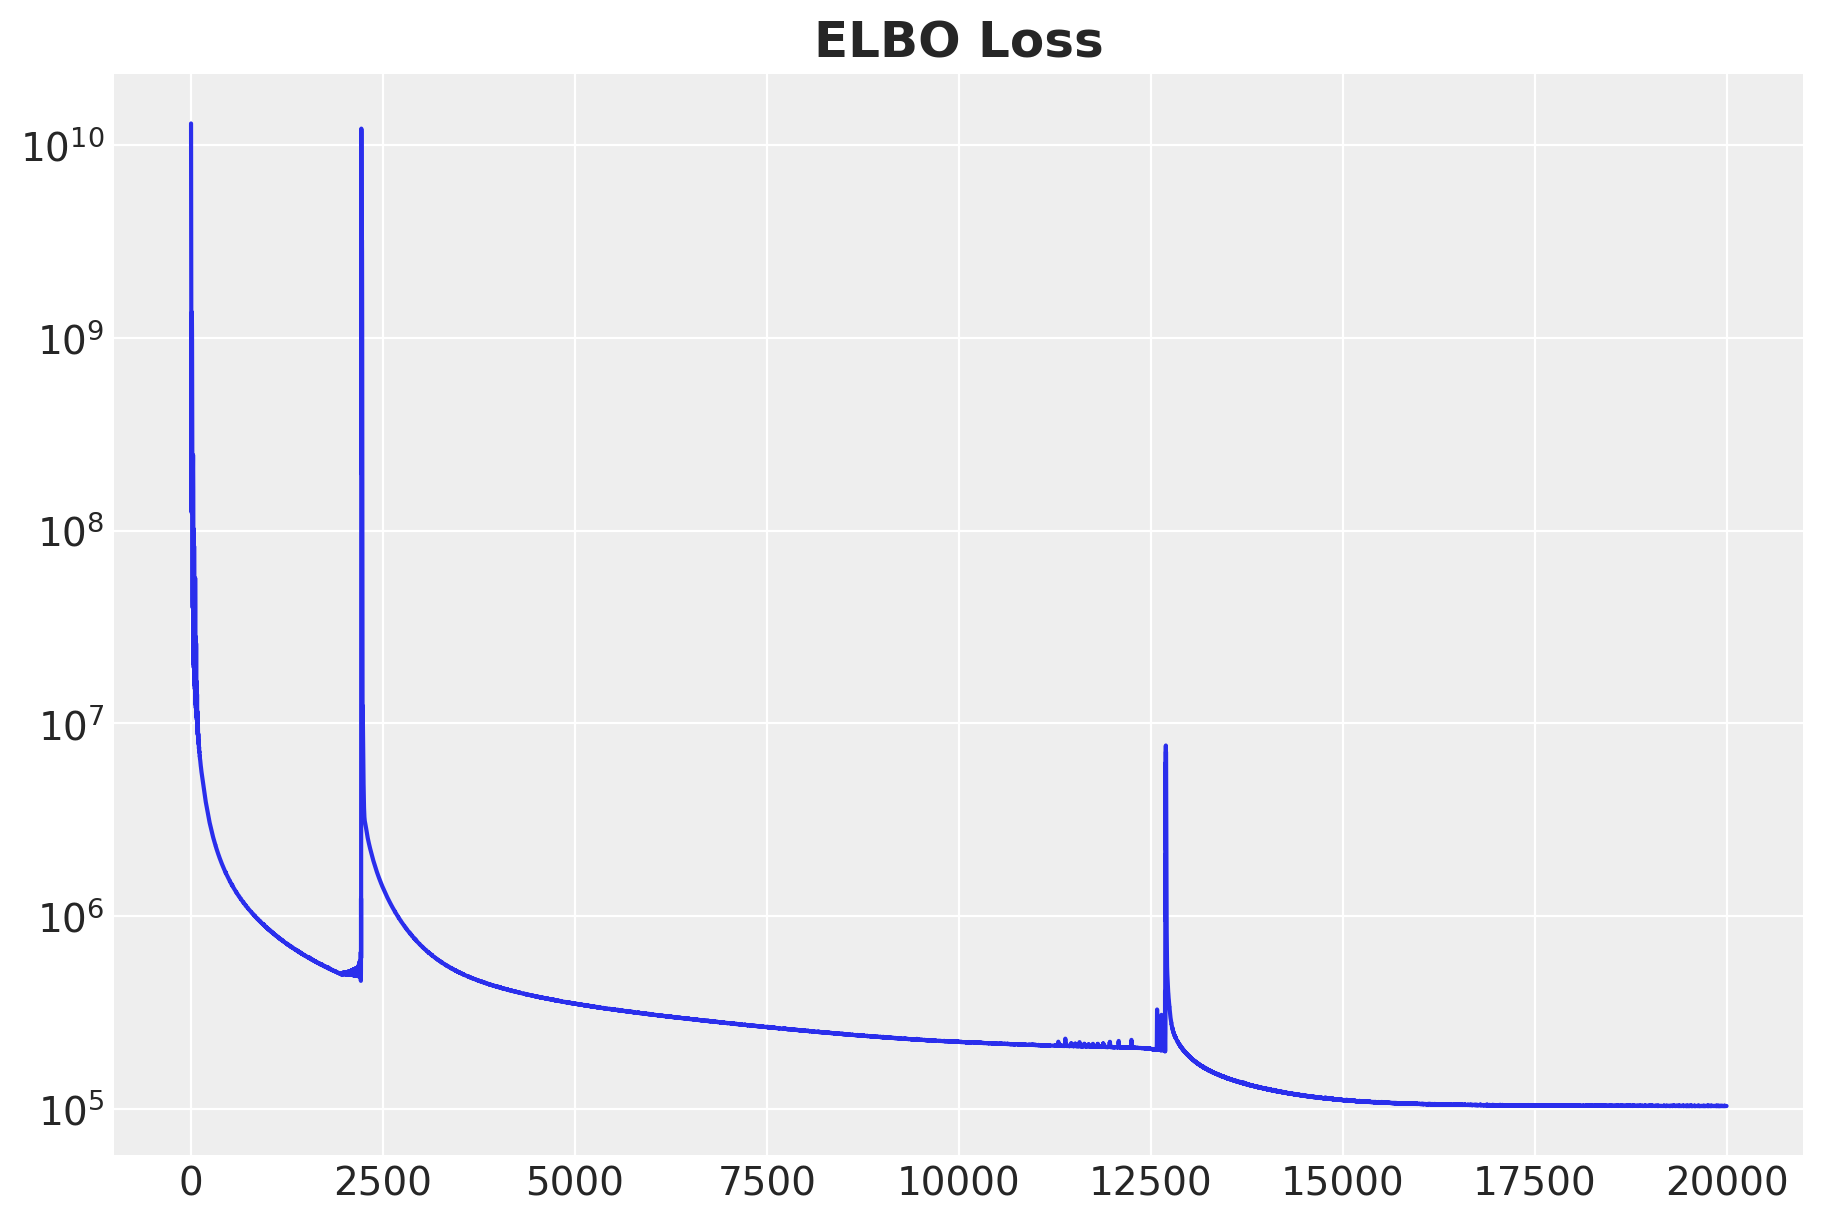

In [16]:
n_samples = 20_000
scheduler = optax.linear_onecycle_schedule(
    transition_steps=n_samples,
    peak_value=0.05,
    pct_start=0.01,
    pct_final=0.75,
    div_factor=2,
    final_div_factor=3,
)

optimizer = optax.chain(
    optax.adam(learning_rate=scheduler),
    optax.contrib.reduce_on_plateau(
        factor=0.1,
        patience=20,
        accumulation_size=200,
    ),
)

svi = SVI(conditioned_model, guide, optimizer, loss=Trace_ELBO())
rng_key, rng_subkey = random.split(key=rng_key)
svi_result = svi.run(
    rng_subkey,
    n_samples,
    is_guild_member=is_guild_member,
    is_highly_engaged=is_highly_engaged,
    won_items=won_items,
    in_game_purchases=in_game_purchases,
)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set(yscale="log")
ax.set_title("ELBO Loss", fontsize=18, fontweight="bold");

In [11]:
params = svi_result.params

posterior_predictive = Predictive(
    model=model,
    guide=guide,
    params=params,
    num_samples=4 * 2_000,
    return_sites=[
        "in_game_purchases",
    ],
)
rng_key, rng_subkey = random.split(key=rng_key)
posterior_predictive_samples = posterior_predictive(
    rng_subkey,
    is_guild_member,
    is_highly_engaged,
    won_items,
    in_game_purchases,
)

idata = az.from_dict(
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in posterior_predictive_samples.items()
    },
    observed_data={
        "in_game_purchases": in_game_purchases,
    },
    coords={"obs_idx": range(df.shape[0])},
    dims={
        "in_game_purchases": ["obs_idx"],
    },
)

<Axes: xlabel='in_game_purchases'>

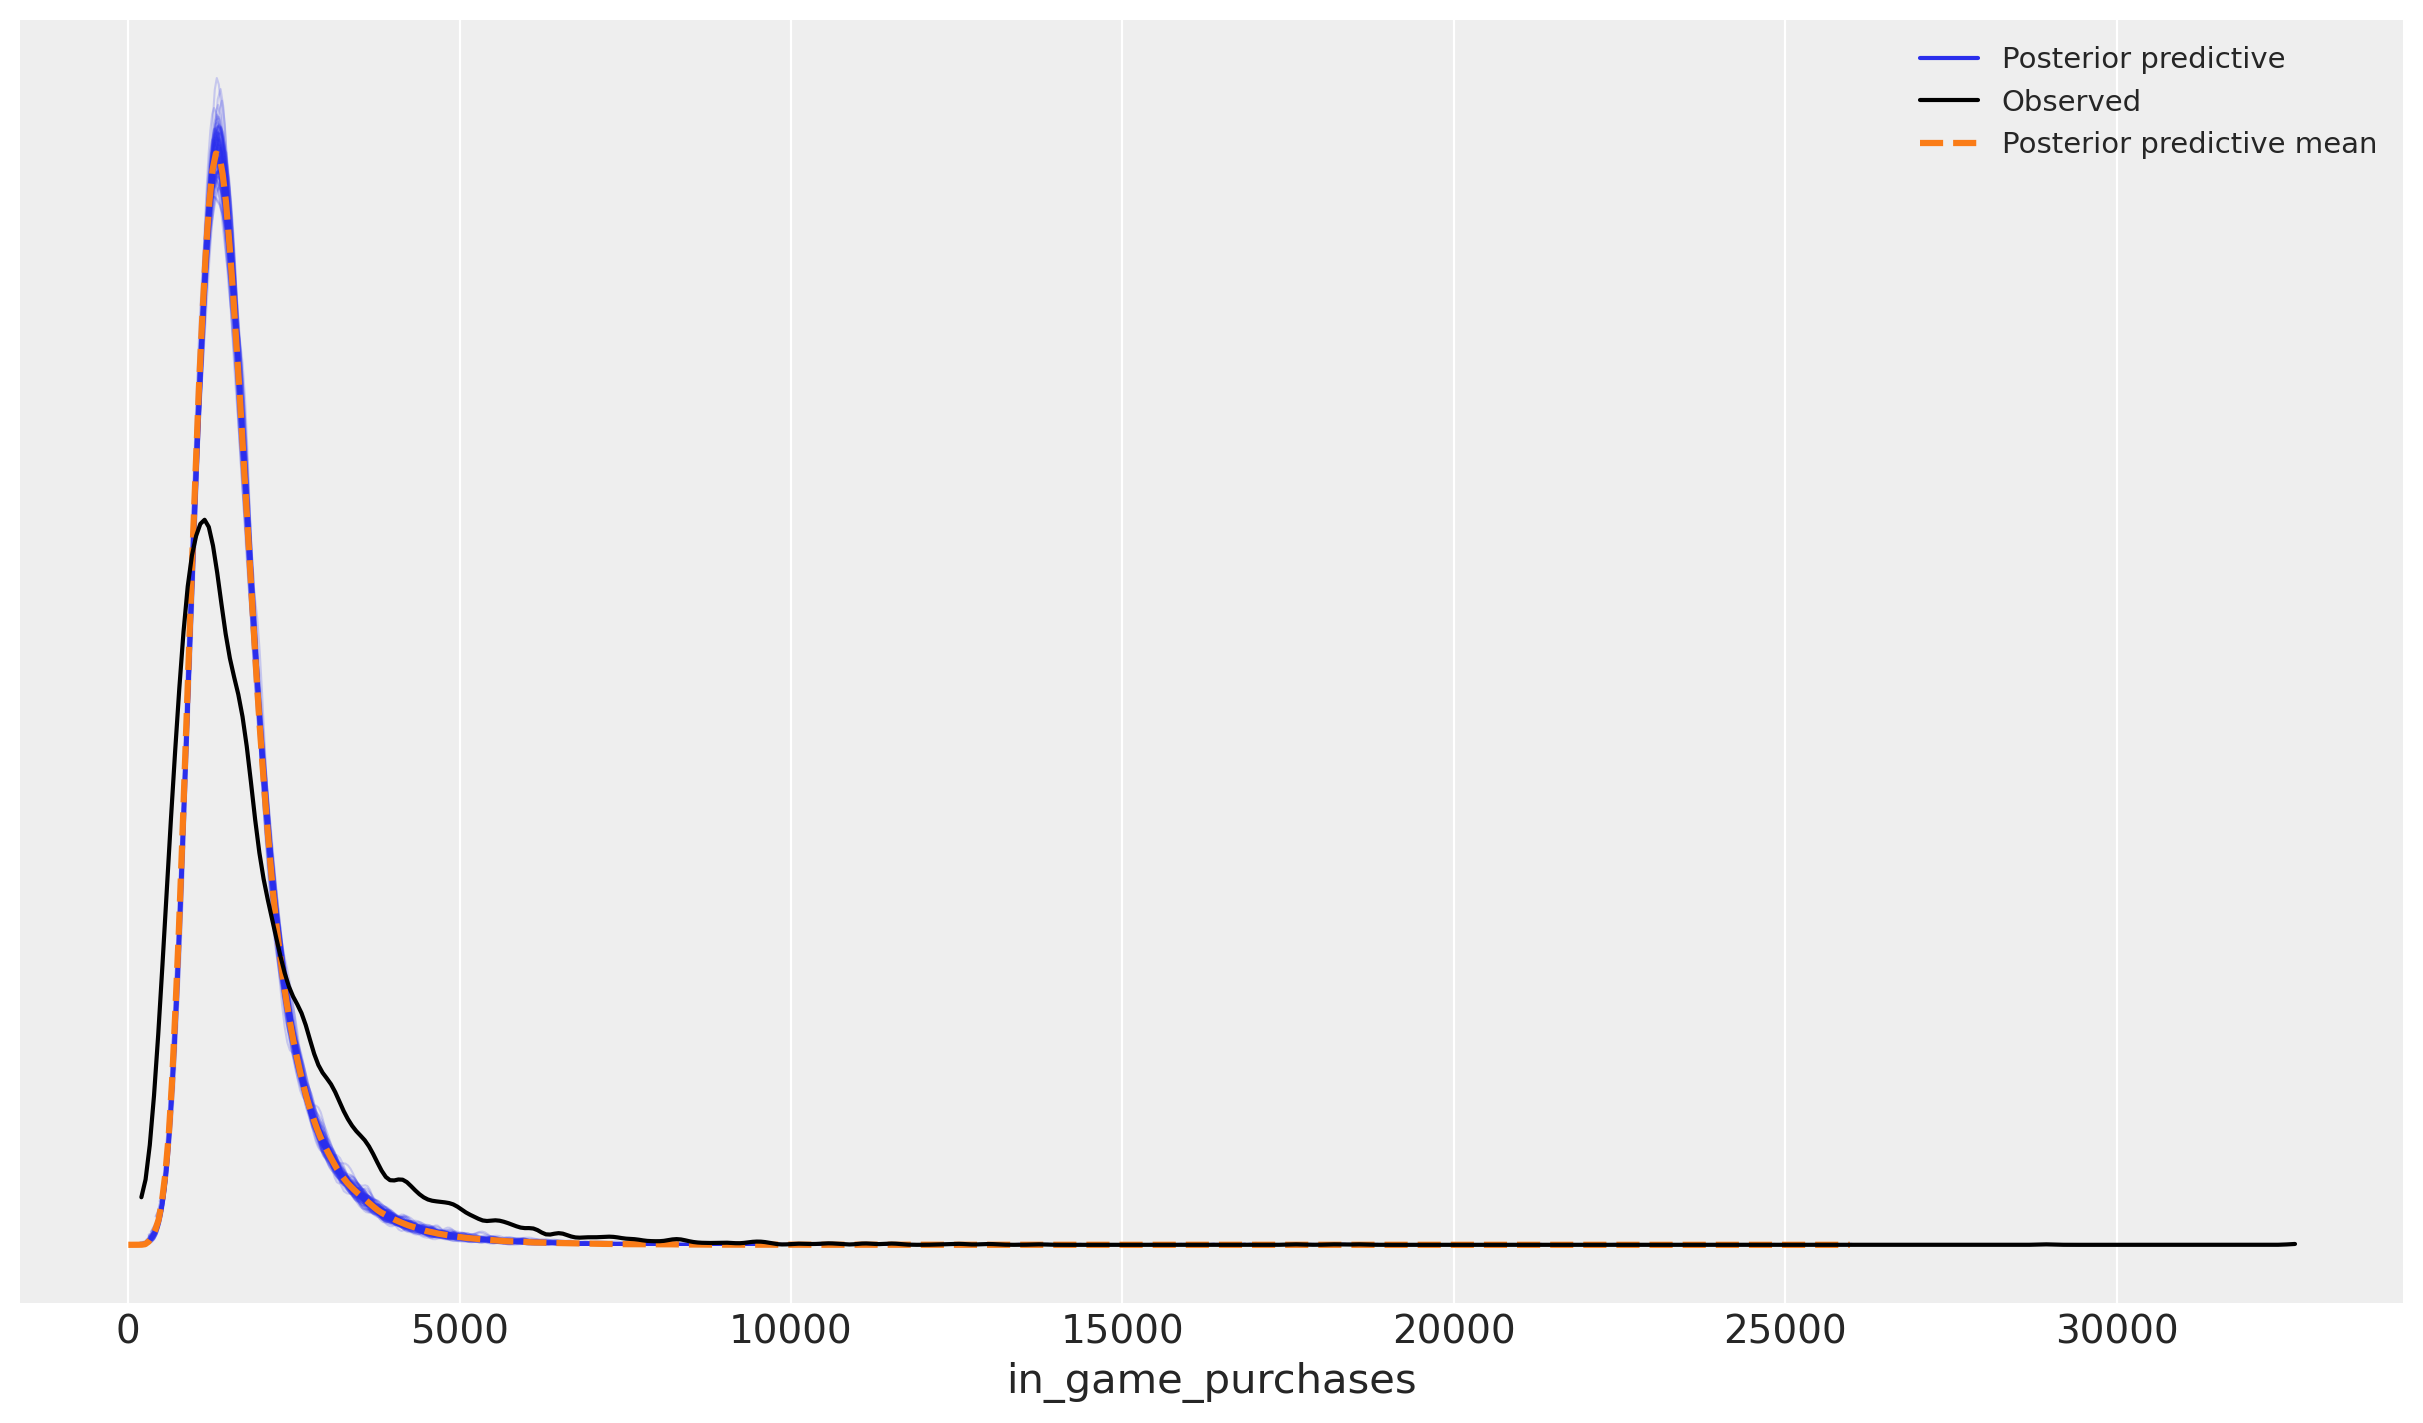

In [12]:
az.plot_ppc(idata, num_pp_samples=100, group="posterior")

In [13]:
do_0_model = do(model, data={"is_highly_engaged": 0})
do_0_posterior_predictive = Predictive(
    model=do_0_model,
    guide=guide,
    params=params,
    num_samples=4 * 2_000,
    return_sites=[
        "in_game_purchases",
    ],
)
rng_key, rng_subkey = random.split(rng_key)
do_0_posterior_predictive_samples = do_0_posterior_predictive(
    rng_subkey,
    is_guild_member,
    jnp.zeros_like(is_highly_engaged),
    won_items,
    in_game_purchases,
)
do_0_idata = az.from_dict(
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in do_0_posterior_predictive_samples.items()
    },
    observed_data={
        "in_game_purchases": in_game_purchases,
    },
    coords={"obs_idx": range(df.shape[0])},
    dims={
        "in_game_purchases": ["obs_idx"],
    },
)

do_1_model = do(model, data={"is_highly_engaged": 1})
do_1_posterior_predictive = Predictive(
    model=do_1_model,
    guide=guide,
    params=params,
    num_samples=4 * 2_000,
    return_sites=[
        "in_game_purchases",
    ],
)

rng_key, rng_subkey = random.split(rng_key)
do_1_posterior_predictive_samples = do_1_posterior_predictive(
    rng_subkey,
    is_guild_member,
    jnp.ones_like(is_highly_engaged),
    won_items,
    in_game_purchases,
)
do_1_idata = az.from_dict(
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in do_1_posterior_predictive_samples.items()
    },
    observed_data={
        "in_game_purchases": in_game_purchases,
    },
    coords={"obs_idx": range(df.shape[0])},
    dims={
        "in_game_purchases": ["obs_idx"],
    },
)

<Axes: title={'center': 'in_game_purchases'}>

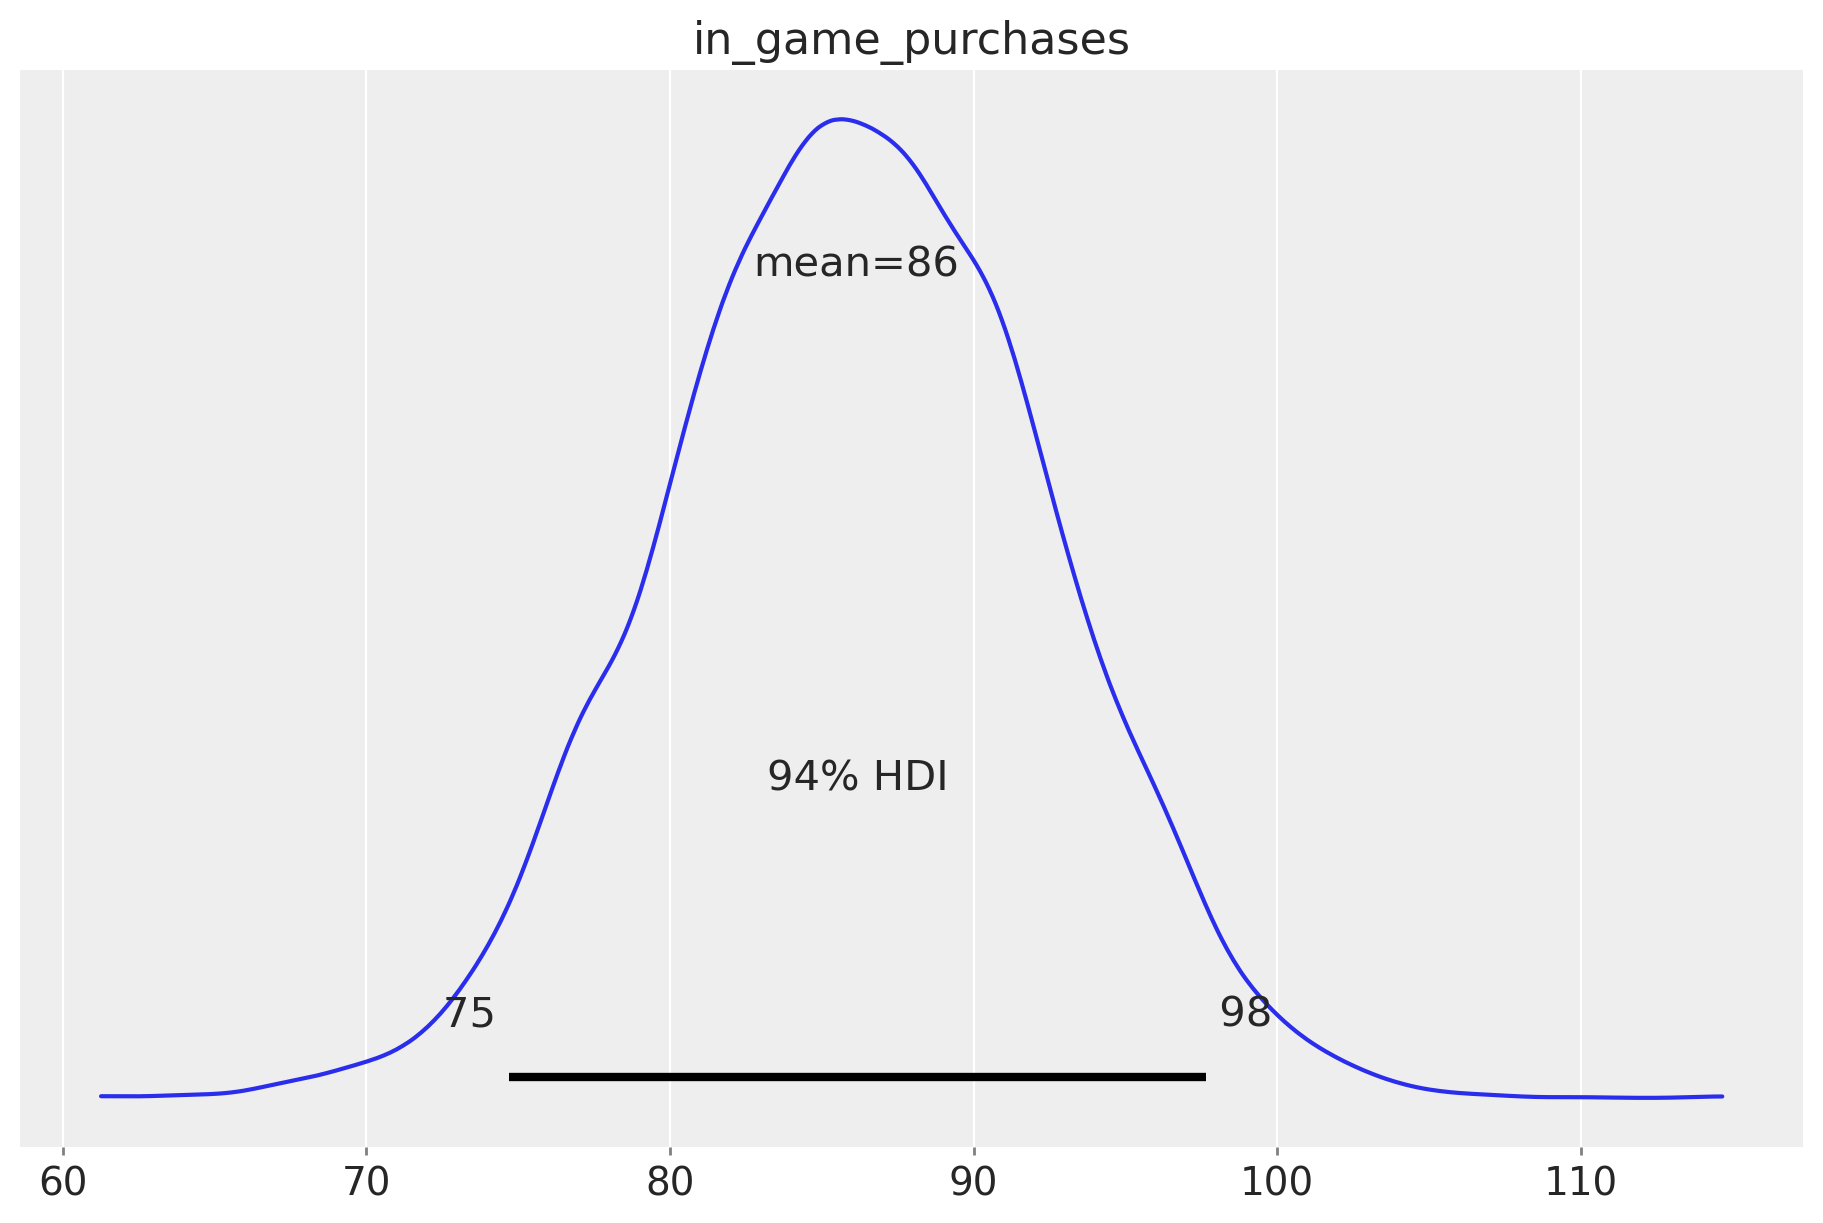

In [14]:
ate = (
    do_1_idata["posterior_predictive"]["in_game_purchases"]
    - do_0_idata["posterior_predictive"]["in_game_purchases"]
).mean(dim="obs_idx")


fig, ax = plt.subplots(figsize=(9, 6))
az.plot_posterior(ate, ax=ax)

array([<Axes: xlabel='in_game_purchases'>], dtype=object)

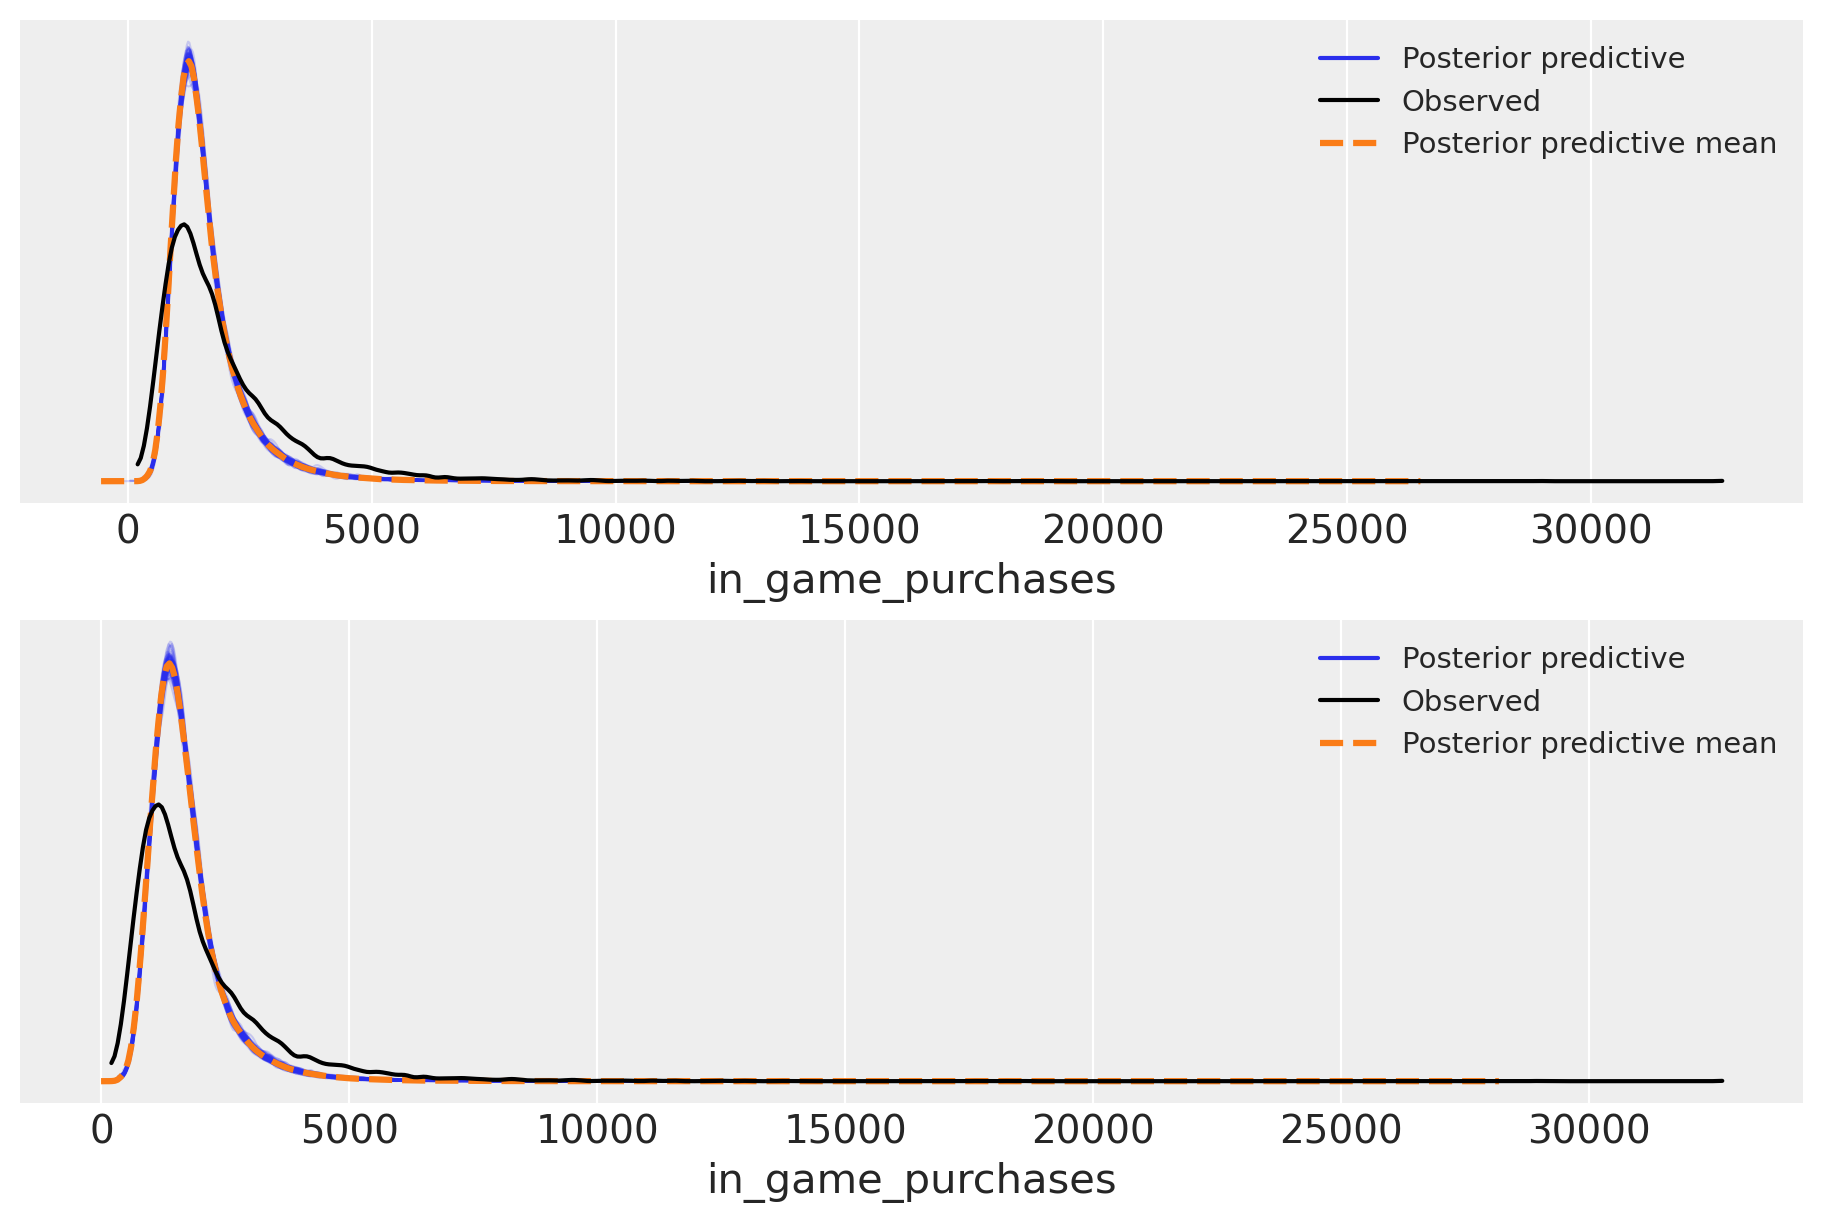

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9, 6))
az.plot_ppc(do_0_idata, num_pp_samples=100, group="posterior", ax=ax[0])
az.plot_ppc(do_1_idata, num_pp_samples=100, group="posterior", ax=ax[1])